<a href="https://colab.research.google.com/github/chien314/Image-classification/blob/main/CIFAR_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Image Classification with PyTorch

## Part 0 Imports and Basic Setup

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim

import matplotlib.pyplot as plt

In [2]:
import torch.cuda as cuda

# Use a GPU, i.e. cuda:0 device if it available.
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
print(device)

cuda:0


### Training Code

In [3]:
import time

class Flatten(nn.Module):
  """NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)
  
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
  all_training_loss = np.zeros((0,2))
  all_training_acc = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_acc = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_acc = 2.0, 0.0
  print_every = 1000
  
  start = time.perf_counter()
  
  for i in range(num_epochs):
    epoch_start = time.perf_counter() 
   
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      training_acc += (torch.argmax(preds, dim=1)==labels).float().mean()
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_acc /= print_every
        
        all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
        all_training_acc = np.concatenate((all_training_acc, [[training_step, training_acc]]))
        
        print('  Epoch %d @ step %d: Train Loss: %3f, Train Accuracy: %3f' % (
            i, training_step, training_loss, training_acc))
        training_loss, training_acc = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_acc = 0.0, 0.0
      count = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        validation_acc+=(torch.argmax(output, dim=1) == labels).float().mean()
        count += 1
      validation_loss/=count
      validation_acc/=count
      
      all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
      all_test_acc = np.concatenate((all_test_acc, [[training_step, validation_acc]]))
      
      epoch_time = time.perf_counter() - epoch_start
      
      print('Epoch %d Test Loss: %3f, Test Accuracy: %3f, time: %.1fs' % (
          i, validation_loss, validation_acc, epoch_time))
      
  total_time = time.perf_counter() - start
  print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
      validation_loss, validation_acc, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Load the ** CIFAR-10** dataset and define the transformations.  

In [4]:
!mkdir cifar_data

In [5]:
# Download the data.
from torchvision import datasets, transforms

transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='cifar_data/', download=True, transform=transformations)
test_set = datasets.CIFAR10(root='cifar_data', download=True, train=False, transform=transformations)

Extracting cifar_data/cifar-10-python.tar.gz to cifar_data/
Files already downloaded and verified


Use `DataLoader` to create a loader for the training set and a loader for the testing set.

In [7]:
from torch.utils.data import DataLoader

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

input_shape = np.array(train_set[0][0]).shape
input_dim = input_shape[1]*input_shape[2]*input_shape[0]

In [8]:
training_epochs = 5

## Part 1: CIFAR10 with Fully Connected Neural Netowrk 

In [9]:
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(input_dim, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = TwoLayerModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004340, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 1.927556, Train Accuracy: 0.334750
  Epoch 0 @ step 2000: Train Loss: 1.806460, Train Accuracy: 0.358500
  Epoch 0 @ step 3000: Train Loss: 1.779732, Train Accuracy: 0.370750
  Epoch 0 @ step 4000: Train Loss: 1.783137, Train Accuracy: 0.357125
  Epoch 0 @ step 5000: Train Loss: 1.769098, Train Accuracy: 0.361625
  Epoch 0 @ step 6000: Train Loss: 1.774960, Train Accuracy: 0.365125
Epoch 0 Test Loss: 1.715017, Test Accuracy: 0.384000, time: 31.6s
  Epoch 1 @ step 7000: Train Loss: 1.743453, Train Accuracy: 0.381375
  Epoch 1 @ step 8000: Train Loss: 1.762451, Train Accuracy: 0.376250
  Epoch 1 @ step 9000: Train Loss: 1.734584, Train Accuracy: 0.387500
  Epoch 1 @ step 10000: Train Loss: 1.753304, Train Accuracy: 0.377000
  Epoch 1 @ step 11000: Train Loss: 1.755645, Train Accuracy: 0.376625
  Epoch 1 @ step 12000: Train Loss: 1.737589, Train Accuracy: 0.373500
Epoch 1 Test Loss: 1.738

**Plot the model results**

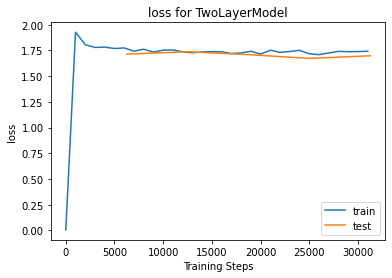

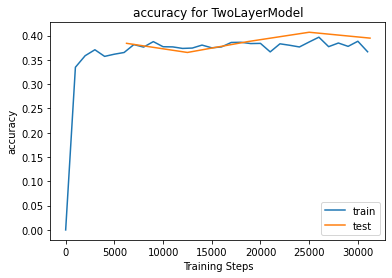

In [10]:
plot_graphs("TwoLayerModel", metrics)

## Part 2: CIFAR10 with Convolutional Neural Network (CNN) 

1. A convolution with	3x3 filter, 16 output channels, stride = 1, padding=1
2. A ReLU activation
2. A Max-Pooling layer with 2x2 window
3. A convolution,	3x3 filter, 16 output channels, stride = 1, padding=1
4. A ReLU activation
4. Flatten layer
5. Fully connected linear layer with output size 64
6. ReLU
7. Fully connected linear layer, with output size 10

In [11]:
class ConvModel(nn.Module):
  def __init__(self):
    super(ConvModel, self).__init__()
    self.net = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3,stride = 1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3,stride = 1, padding=1),        
      nn.ReLU(),
      Flatten(),
      nn.Linear(4096, 64), 
      nn.ReLU(), 
      nn.Linear(64, 10))
    
  def forward(self, x):
    return self.net(x)

model = ConvModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)

metrics = train(model, train_loader, test_loader, loss, optimizer, training_epochs)

  Epoch 0 @ step 0: Train Loss: 0.004304, Train Accuracy: 0.000375
  Epoch 0 @ step 1000: Train Loss: 1.864111, Train Accuracy: 0.327250
  Epoch 0 @ step 2000: Train Loss: 1.612175, Train Accuracy: 0.412625
  Epoch 0 @ step 3000: Train Loss: 1.525769, Train Accuracy: 0.440875
  Epoch 0 @ step 4000: Train Loss: 1.437974, Train Accuracy: 0.478375
  Epoch 0 @ step 5000: Train Loss: 1.408108, Train Accuracy: 0.479375
  Epoch 0 @ step 6000: Train Loss: 1.407921, Train Accuracy: 0.488375
Epoch 0 Test Loss: 1.413080, Test Accuracy: 0.478700, time: 37.0s
  Epoch 1 @ step 7000: Train Loss: 1.395619, Train Accuracy: 0.492250
  Epoch 1 @ step 8000: Train Loss: 1.383005, Train Accuracy: 0.499125
  Epoch 1 @ step 9000: Train Loss: 1.355850, Train Accuracy: 0.502500
  Epoch 1 @ step 10000: Train Loss: 1.342182, Train Accuracy: 0.524625
  Epoch 1 @ step 11000: Train Loss: 1.371780, Train Accuracy: 0.503625
  Epoch 1 @ step 12000: Train Loss: 1.359002, Train Accuracy: 0.507000
Epoch 1 Test Loss: 1.286

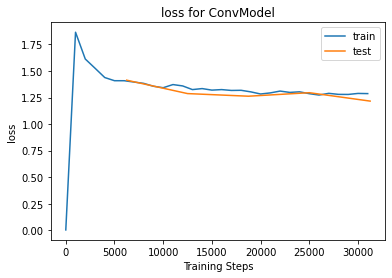

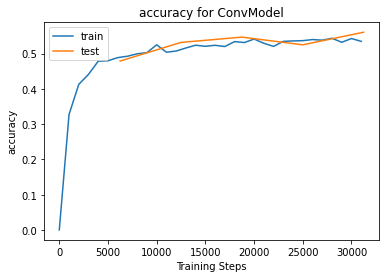

In [12]:
plot_graphs("ConvModel", metrics)

## Part 3: CIFAR10 with Resnet

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.dropout = nn.Dropout(0.5)    

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def AwesomeModel():
    return ResNet(BasicBlock, [3,4,6,3])


In [14]:
model = AwesomeModel().to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

metrics = train(model, train_loader, test_loader, loss, optimizer, 7)

  Epoch 0 @ step 0: Train Loss: 0.004815, Train Accuracy: 0.000000
  Epoch 0 @ step 1000: Train Loss: 2.190252, Train Accuracy: 0.198250
  Epoch 0 @ step 2000: Train Loss: 1.884732, Train Accuracy: 0.287250
  Epoch 0 @ step 3000: Train Loss: 1.761324, Train Accuracy: 0.351375
  Epoch 0 @ step 4000: Train Loss: 1.642815, Train Accuracy: 0.396875
  Epoch 0 @ step 5000: Train Loss: 1.527939, Train Accuracy: 0.438375
  Epoch 0 @ step 6000: Train Loss: 1.416617, Train Accuracy: 0.484125
Epoch 0 Test Loss: 1.251736, Test Accuracy: 0.547200, time: 254.2s
  Epoch 1 @ step 7000: Train Loss: 1.277060, Train Accuracy: 0.535375
  Epoch 1 @ step 8000: Train Loss: 1.184752, Train Accuracy: 0.581125
  Epoch 1 @ step 9000: Train Loss: 1.110262, Train Accuracy: 0.605000
  Epoch 1 @ step 10000: Train Loss: 1.046515, Train Accuracy: 0.628125
  Epoch 1 @ step 11000: Train Loss: 0.987635, Train Accuracy: 0.653250
  Epoch 1 @ step 12000: Train Loss: 0.940809, Train Accuracy: 0.670125
Epoch 1 Test Loss: 0.81

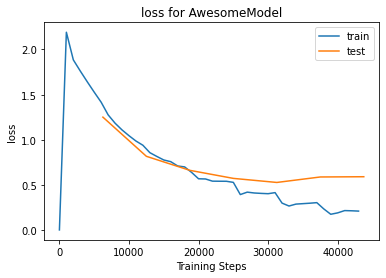

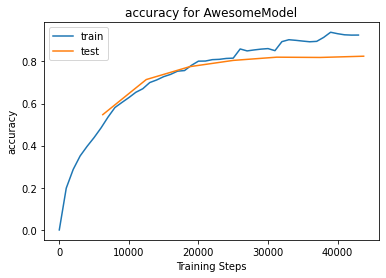

In [15]:
plot_graphs("AwesomeModel", metrics)